In [15]:
# ==========================================================
# BLOCCO 1: Data Cleaning e Aggregazione ottimizzato (ZeekDataFall22)
# ==========================================================

import os
import glob
import pandas as pd
from tqdm import tqdm

# Percorso cartella parquet
folder_path = r"C:\Users\maria\Desktop\Zeek_ML\UWF-ZeekDataFall22"
parquet_files = glob.glob(os.path.join(folder_path, "*.parquet"))

# -----------------------
# 1Ô∏è‚É£ Caricamento incrementale
# -----------------------
dfs = []
for file in tqdm(parquet_files, desc="Caricamento file parquet"):
    dfs.append(pd.read_parquet(file))
data = pd.concat(dfs, ignore_index=True)
print(f"Totale righe iniziali: {len(data)}")
print(f"Totale colonne iniziali: {data.shape[1]}")

# -----------------------
# 2Ô∏è‚É£ Conversione object ‚Üí category per risparmio RAM
# -----------------------
for col in data.select_dtypes(include=['object']).columns:
    data[col] = data[col].astype('category')

# -----------------------
# 3Ô∏è‚É£ Analisi valori mancanti
# -----------------------
col_summary = pd.DataFrame({
    'dtype': data.dtypes,
    'num_missing': data.isna().sum(),
    'perc_missing': data.isna().mean() * 100
}).sort_values('perc_missing', ascending=False)
display(col_summary)

# -----------------------
# 4Ô∏è‚É£ Eliminazione colonne con troppi NaN (>50%)
# -----------------------
threshold = 50
cols_to_drop = col_summary[col_summary['perc_missing'] > threshold].index.tolist()
if cols_to_drop:
    data.drop(columns=cols_to_drop, inplace=True)
    print(f"Colonne eliminate per troppi NaN (> {threshold}%): {cols_to_drop}")
else:
    print("Nessuna colonna da eliminare per troppi NaN.")

# -----------------------
# 5Ô∏è‚É£ Rimozione duplicati (solo colonne chiave per risparmio RAM)
# -----------------------
subset_cols = ['uid', 'ts', 'orig_bytes', 'resp_bytes'] if 'uid' in data.columns else None
duplicates_before = data.duplicated(subset=subset_cols).sum()
data = data.drop_duplicates(subset=subset_cols)
print(f"Duplicati rimossi: {duplicates_before}")

# -----------------------
# 6Ô∏è‚É£ Imputazione valori mancanti
# -----------------------
num_cols = data.select_dtypes(include=['int64','float64']).columns
cat_cols = data.select_dtypes(include=['category']).columns

for col in num_cols:
    if data[col].isna().any():
        data[col].fillna(data[col].mean(), inplace=True)
for col in cat_cols:
    if data[col].isna().any():
        mode_val = data[col].mode()
        data[col].fillna(mode_val[0] if not mode_val.empty else 'unknown', inplace=True)

# -----------------------
# 7Ô∏è‚É£ Aggregazioni session-level features
# -----------------------
if 'uid' not in data.columns:
    data['uid'] = range(len(data))

session_features = data.groupby('uid').agg(
    total_orig_bytes=('orig_bytes', 'sum'),
    total_resp_bytes=('resp_bytes', 'sum'),
    total_orig_pkts=('orig_pkts', 'sum'),
    total_resp_pkts=('resp_pkts', 'sum'),
    mean_duration=('duration', 'mean')
).reset_index()

data = pd.merge(data, session_features, on='uid', how='left')
print(f"Totale sessioni aggregate: {session_features.shape[0]}")

# -----------------------
# 8Ô∏è‚É£ Anteprima finale
# -----------------------
display(data.head())
print("‚úÖ Data Cleaning e Aggregazioni completati.")

Caricamento file parquet: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:00<00:00, 23.27it/s]


Totale righe iniziali: 700340
Totale colonne iniziali: 25


dtype  num_missing  perc_missing
service                category       317407     45.321844
duration                float64       317051     45.271011
orig_bytes              float64       317051     45.271011
resp_bytes              float64       317051     45.271011
history                category         8206      1.171717
community_id           category            0      0.000000
proto                  category            0      0.000000
label_technique        category            0      0.000000
label_tactic           category            0      0.000000
datetime         datetime64[ns]            0      0.000000
uid                    category            0      0.000000
ts                      float64            0      0.000000
resp_pkts                 int64            0      0.000000
resp_ip_bytes             int64            0      0.000000
orig_ip_bytes             int64            0      0.000000
orig_pkts                 int64            0      0.000000
conn_state             category            0      0.000000
missed_bytes              int64            0      0.000000
local_resp                 bool            0      0.000000
local_orig                 bool            0      0.000000
dest_port_zeek            int64            0      0.000000
dest_ip_zeek           category            0      0.000000
src_port_zeek             int64            0      0.000000
src_ip_zeek            category            0      0.000000
label_binary           category            0      0.000000

Nessuna colonna da eliminare per troppi NaN.
Duplicati rimossi: 39967


C:\Users\maria\AppData\Local\Temp\ipykernel_25304\286670642.py:79: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  session_features = data.groupby('uid').agg(


Totale sessioni aggregate: 660373


community_id conn_state   duration   history  \
0  1:ktX8uiwrFpzrBHnE1G51yTAiiQo=         S1  41.878964     ShAdD   
1  1:52yAKDtnHSPDIljwNPlA+UWODdA=         SF   0.041849  ShAdDFaf   
2  1:CLE/zfbKMSEi1spOm7y0JJKUgO4=         SF   0.046801  ShAdDFaf   
3  1:TTpmQx1wKxVI3KmlIDAsdr/5rXg=         S1   0.012059    ShAdDa   
4  1:VhB7MbbJ52hjItNqXYgI9n8660Q=         SF   0.013730        Dd   

    src_ip_zeek  src_port_zeek  dest_ip_zeek  dest_port_zeek  local_orig  \
0  143.88.10.11          42296  143.88.10.13            9999       False   
1  143.88.10.11          57042  143.88.10.16            9999       False   
2  143.88.10.11          57044  143.88.10.16            9999       False   
3  143.88.10.11          57046  143.88.10.16            9999       False   
4  143.88.20.12             68   143.88.20.1              67       False   

   local_resp  ...                 uid                datetime  label_tactic  \
0       False  ...   CrA3emsiAM5XvugO6 2022-10-23 22:07:45.793   Persistence   
1       False  ...  CqO92B3QWHYhyPdtse 2022-10-05 18:14:34.531     Execution   
2       False  ...   CPwSIpstvV2fZBc4k 2022-10-05 18:14:51.275     Execution   
3       False  ...   Cy4bYOmyBBGRSvod9 2022-10-05 18:14:57.059     Execution   
4       False  ...  CMcgot3HfOuCDV3s11 2022-10-04 11:40:45.900    Collection   

   label_technique label_binary  total_orig_bytes  total_resp_bytes  \
0            T1546         True              11.0            1847.0   
1            T1059         True             114.0              73.0   
2            T1059         True            1014.0              73.0   
3            T1059         True            3008.0              51.0   
4            T1557         True             600.0             600.0   

   total_orig_pkts total_resp_pkts  mean_duration  
0                7               5      41.878964  
1                9               6       0.041849  
2                9               6       0.046801  
3                6               3       0.012059  
4                2               2       0.013730  

[5 rows x 30 columns]

‚úÖ Data Cleaning e Aggregazioni completati.


In [16]:
# ==========================================================
# BLOCCO 2: Controllo valori nulli e riepilogo colonne/feature
# ==========================================================

# Controllo valori nulli residui
null_counts = data.isna().sum()
null_cols = null_counts[null_counts > 0]

if len(null_cols) == 0:
    print("‚úÖ Non ci sono valori nulli residui.")
else:
    print("‚ö†Ô∏è Colonne con valori nulli residui:")
    display(null_cols)

# Riepilogo colonne e feature rimaste dopo data cleaning e aggregazioni
print("\nüìä Colonne e feature disponibili per l'analisi:")
for i, col in enumerate(data.columns):
    print(f"{i+1}. {col}")

# Opzionale: possiamo separare feature numeriche e categoriali per la fase successiva
num_features = data.select_dtypes(include=['int64','float64']).columns.tolist()
cat_features = data.select_dtypes(include=['object','category']).columns.tolist()

print("\nüîπ Feature numeriche:")
print(num_features)
print("\nüîπ Feature categoriali:")
print(cat_features)
# --------------------------
# Salvataggio feature categoriali
# --------------------------
cat_features_df = data[cat_features].copy()
cat_features_df.to_parquet(r"C:\Users\maria\Desktop\Zeek_ML\processed_zeekdata22\categorical_features.parquet", index=False)
print(f"üíæ Feature categoriali salvate: {cat_features_df.shape[1]} colonne, {cat_features_df.shape[0]} righe")

‚úÖ Non ci sono valori nulli residui.

üìä Colonne e feature disponibili per l'analisi:
1. community_id
2. conn_state
3. duration
4. history
5. src_ip_zeek
6. src_port_zeek
7. dest_ip_zeek
8. dest_port_zeek
9. local_orig
10. local_resp
11. missed_bytes
12. orig_bytes
13. orig_ip_bytes
14. orig_pkts
15. proto
16. resp_bytes
17. resp_ip_bytes
18. resp_pkts
19. service
20. ts
21. uid
22. datetime
23. label_tactic
24. label_technique
25. label_binary
26. total_orig_bytes
27. total_resp_bytes
28. total_orig_pkts
29. total_resp_pkts
30. mean_duration

üîπ Feature numeriche:
['duration', 'src_port_zeek', 'dest_port_zeek', 'missed_bytes', 'orig_bytes', 'orig_ip_bytes', 'orig_pkts', 'resp_bytes', 'resp_ip_bytes', 'resp_pkts', 'ts', 'total_orig_bytes', 'total_resp_bytes', 'total_orig_pkts', 'total_resp_pkts', 'mean_duration']

üîπ Feature categoriali:
['community_id', 'conn_state', 'history', 'src_ip_zeek', 'dest_ip_zeek', 'proto', 'service', 'uid', 'label_tactic', 'label_technique', 'label_b

üìä Analisi esplorativa della label_tactic...

Distribuzione label_tactic:


count      %
label_tactic                       
none                  350339  53.05
Resource Development  262409  39.74
Reconnaissance         28661   4.34
Discovery              16020   2.43
Defense Evasion         2894   0.44
Initial Access            16   0.00
Command and Control       14   0.00
Execution                  8   0.00
Lateral Movement           6   0.00
Persistence                5   0.00
Collection                 1   0.00
Credential Access          0   0.00
Privilege Escalation       0   0.00

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\maria\AppData\Local\Temp\ipykernel_25304\2105770508.py:26: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


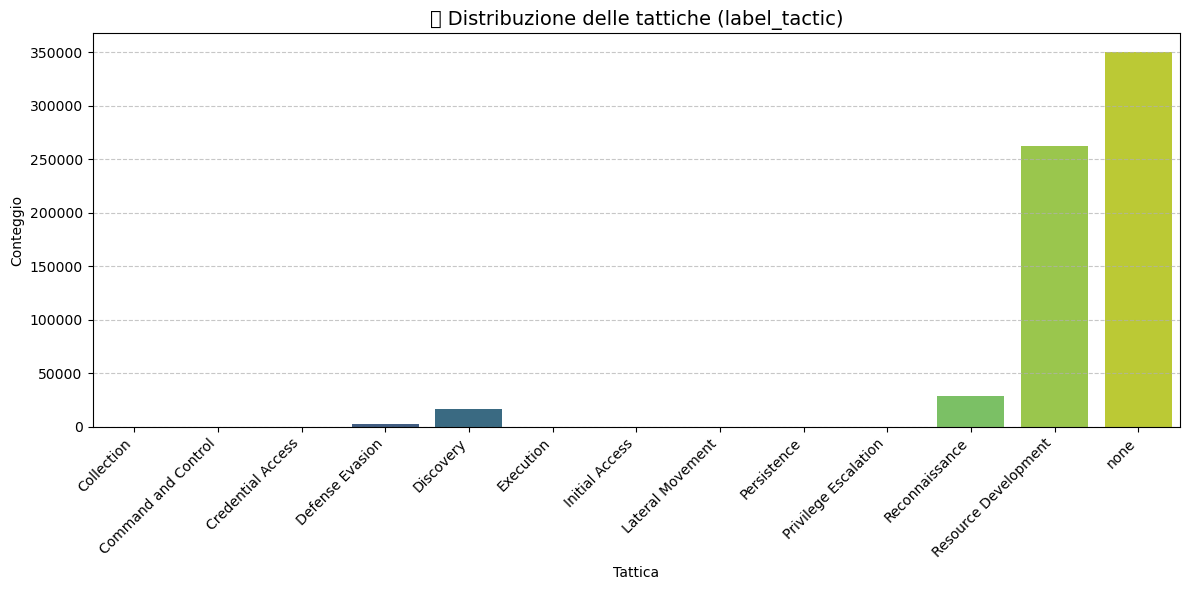


üîπ Percentuale cumulativa delle tattiche:


count      %  cumulative_%
label_tactic                                     
none                  350339  53.05         53.05
Resource Development  262409  39.74         92.79
Reconnaissance         28661   4.34         97.13
Discovery              16020   2.43         99.56
Defense Evasion         2894   0.44        100.00
Initial Access            16   0.00        100.00
Command and Control       14   0.00        100.00
Execution                  8   0.00        100.00
Lateral Movement           6   0.00        100.00
Persistence                5   0.00        100.00
Collection                 1   0.00        100.00
Credential Access          0   0.00        100.00
Privilege Escalation       0   0.00        100.00


üîπ Classi principali (>5% del totale):


count      %  cumulative_%
label_tactic                                     
none                  350339  53.05         53.05
Resource Development  262409  39.74         92.79

In [17]:
# ==========================================================
# BLOCCO 3: Analisi esplorativa della label_tactic
# ==========================================================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("üìä Analisi esplorativa della label_tactic...\n")

# 1Ô∏è‚É£ Distribuzione generale
tactic_counts = data['label_tactic'].value_counts()
tactic_perc = tactic_counts / tactic_counts.sum() * 100
tactic_summary = pd.concat([tactic_counts, tactic_perc.round(2)], axis=1)
tactic_summary.columns = ['count', '%']
print("Distribuzione label_tactic:")
display(tactic_summary)

# 2Ô∏è‚É£ Visualizzazione grafica
plt.figure(figsize=(12,6))
sns.barplot(x=tactic_counts.index, y=tactic_counts.values, palette='viridis')
plt.title("üìä Distribuzione delle tattiche (label_tactic)", fontsize=14)
plt.xlabel("Tattica")
plt.ylabel("Conteggio")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 3Ô∏è‚É£ Eventuali analisi aggiuntive
# Percentuale cumulativa
tactic_summary['cumulative_%'] = tactic_summary['%'].cumsum()
print("\nüîπ Percentuale cumulativa delle tattiche:")
display(tactic_summary[['count','%','cumulative_%']])

# 4Ô∏è‚É£ Evidenzia classi principali (>5% del totale)
main_classes = tactic_summary[tactic_summary['%'] > 5]
print("\nüîπ Classi principali (>5% del totale):")
display(main_classes)


‚öôÔ∏è Rimozione del traffico benigno ('none') e aggiornamento distribuzioni...

üìã Totale record: 660373
‚ö†Ô∏è Campioni benigni ('none') rilevati: 350339 (53.05%)

üìä Distribuzione 'label_technique' PRIMA della rimozione dei benigni:


Conteggio  Percentuale (%)
label_technique                            
none                350339            53.05
T1587               262409            39.74
T1592                20382             3.09
T1046                16020             2.43
T1595                 8104             1.23
T1548                 2893             0.44
T1589                  135             0.02
T1590                   40             0.01
T1071                   12             0.00
T1566                    9             0.00
T1190                    6             0.00
T1210                    6             0.00
T1059                    5             0.00
T1136                    3             0.00
T1203                    3             0.00
T1571                    2             0.00
T1546                    1             0.00
T1557                    1             0.00
T1505                    1             0.00
T1133                    1             0.00
T1112                    1             0.00
T1547                    0             0.00
T1204                    0             0.00
Duplicate                0             0.00

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\maria\AppData\Local\Temp\ipykernel_25304\2400587127.py:45: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


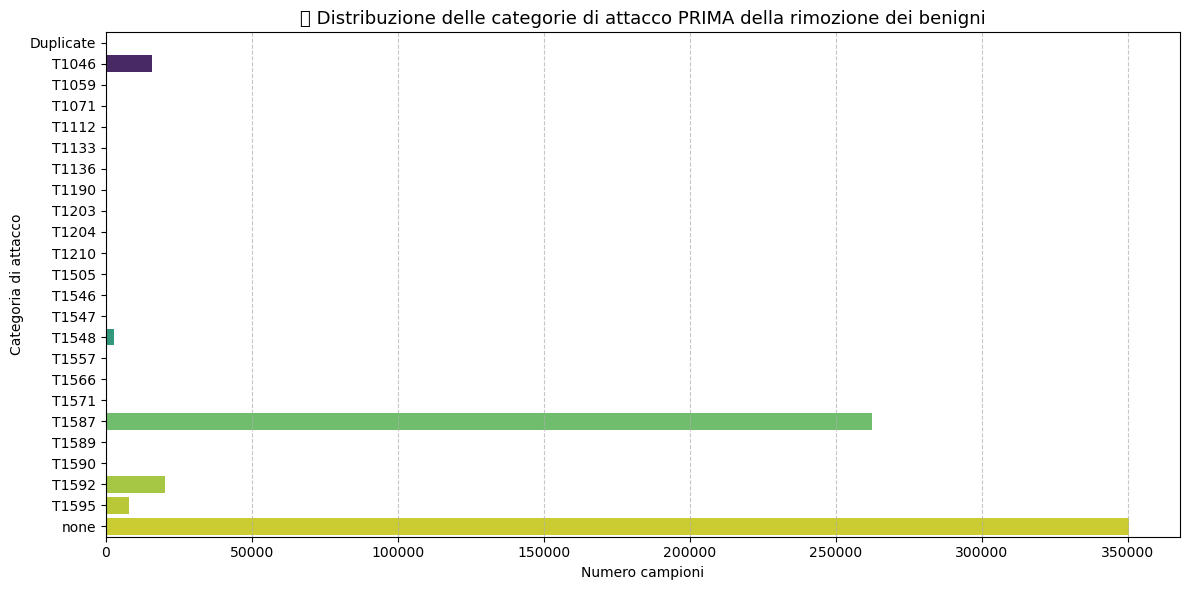

‚úÖ Dopo la rimozione: 310034 righe rimanenti (46.95% del totale).

üìä Distribuzione 'label_technique' DOPO la rimozione dei benigni:


Conteggio  Percentuale (%)
label_technique                            
T1587               262409            84.64
T1592                20382             6.57
T1046                16020             5.17
T1595                 8104             2.61
T1548                 2893             0.93
T1589                  135             0.04
T1590                   40             0.01
T1071                   12             0.00
T1566                    9             0.00
T1210                    6             0.00
T1190                    6             0.00
T1059                    5             0.00
T1203                    3             0.00
T1136                    3             0.00
T1571                    2             0.00
T1505                    1             0.00
T1133                    1             0.00
T1557                    1             0.00
T1112                    1             0.00
T1546                    1             0.00
Duplicate                0             0.00
T1547                    0             0.00
T1204                    0             0.00
none                     0             0.00

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\maria\AppData\Local\Temp\ipykernel_25304\2400587127.py:73: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


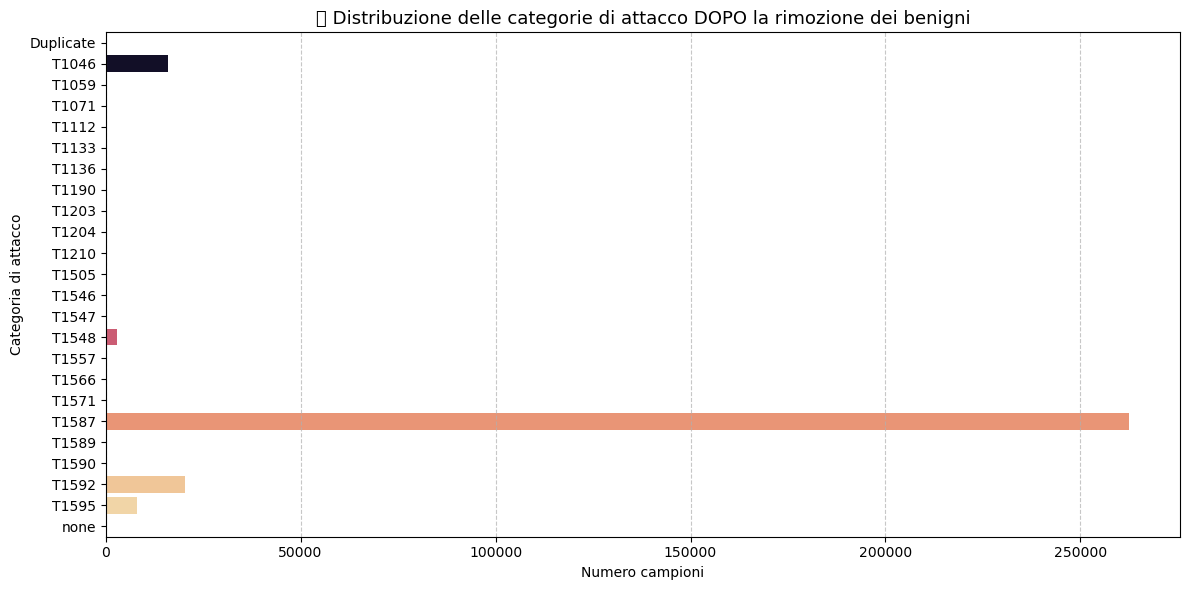


üìä Distribuzione 'label_tactic' DOPO la rimozione dei benigni:


Conteggio  Percentuale (%)
label_tactic                                    
Resource Development     262409            84.64
Reconnaissance            28661             9.24
Discovery                 16020             5.17
Defense Evasion            2894             0.93
Initial Access               16             0.01
Command and Control          14             0.00
Execution                     8             0.00
Lateral Movement              6             0.00
Persistence                   5             0.00
Collection                    1             0.00
Credential Access             0             0.00
Privilege Escalation          0             0.00
none                          0             0.00

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\maria\AppData\Local\Temp\ipykernel_25304\2400587127.py:95: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


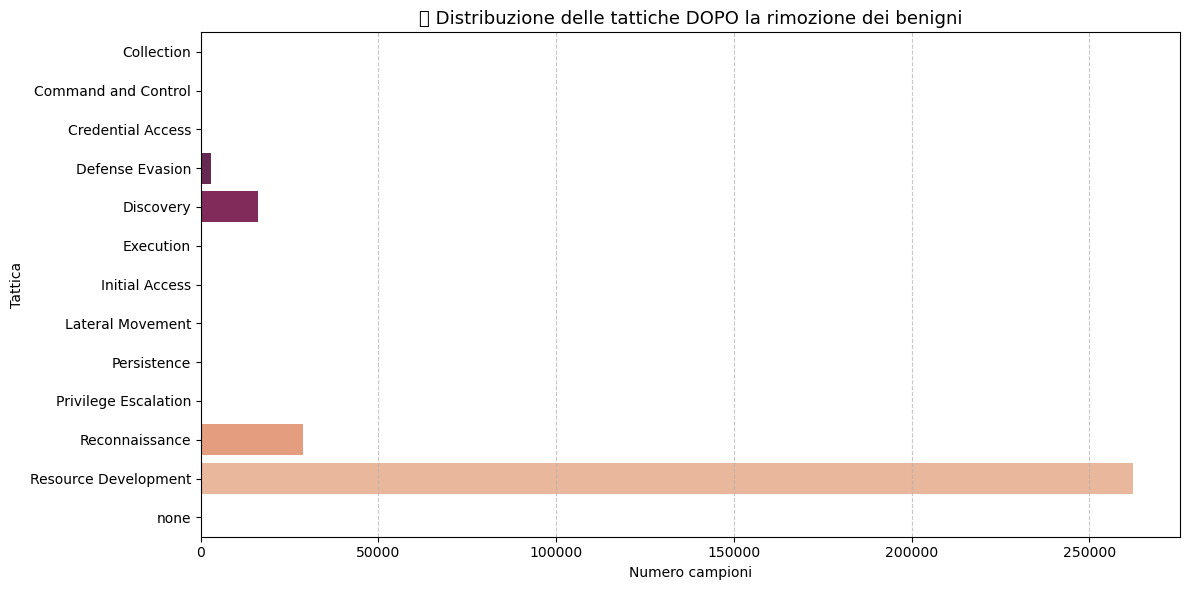

In [18]:
# ==========================================================
# BLOCCO 4: Rimozione traffico benigno ("none") e analisi post-rimozione
# ==========================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("‚öôÔ∏è Rimozione del traffico benigno ('none') e aggiornamento distribuzioni...\n")

# ---------------------------
# 1Ô∏è‚É£ Controllo colonne obbligatorie
# ---------------------------
if 'label_technique' not in data.columns:
    raise KeyError("‚ö†Ô∏è Manca la colonna 'label_technique' nel dataset caricato.")
if 'label_tactic' not in data.columns:
    print("‚ö†Ô∏è Colonna 'label_tactic' non trovata: verr√† saltata l'analisi tattiche post-rimozione.")

# ---------------------------
# 2Ô∏è‚É£ Analisi preliminare prima della rimozione
# ---------------------------
total_count = len(data)
none_count = (data['label_technique'] == 'none').sum()
perc_none = (none_count / total_count) * 100

print(f"üìã Totale record: {total_count}")
print(f"‚ö†Ô∏è Campioni benigni ('none') rilevati: {none_count} ({perc_none:.2f}%)\n")

# Tabella di riepilogo pre-rimozione
tech_counts_before = data['label_technique'].value_counts()
tech_perc_before = (tech_counts_before / total_count * 100).round(2)
tech_summary_before = pd.DataFrame({
    'Conteggio': tech_counts_before,
    'Percentuale (%)': tech_perc_before
})
print("üìä Distribuzione 'label_technique' PRIMA della rimozione dei benigni:")
display(tech_summary_before)

# Grafico pre-rimozione
plt.figure(figsize=(12,6))
sns.barplot(x=tech_counts_before.values, y=tech_counts_before.index, palette='viridis')
plt.title("üìä Distribuzione delle categorie di attacco PRIMA della rimozione dei benigni", fontsize=13)
plt.xlabel("Numero campioni")
plt.ylabel("Categoria di attacco")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# ---------------------------
# 3Ô∏è‚É£ Rimozione traffico benigno
# ---------------------------
data = data[data['label_technique'] != 'none'].reset_index(drop=True)
print(f"‚úÖ Dopo la rimozione: {len(data)} righe rimanenti ({len(data)/total_count*100:.2f}% del totale).\n")

# ---------------------------
# 4Ô∏è‚É£ Analisi post-rimozione
# ---------------------------
tech_counts_after = data['label_technique'].value_counts()
tech_perc_after = (tech_counts_after / len(data) * 100).round(2)
tech_summary_after = pd.DataFrame({
    'Conteggio': tech_counts_after,
    'Percentuale (%)': tech_perc_after
})
print("üìä Distribuzione 'label_technique' DOPO la rimozione dei benigni:")
display(tech_summary_after)

# Grafico post-rimozione
plt.figure(figsize=(12,6))
sns.barplot(x=tech_counts_after.values, y=tech_counts_after.index, palette='magma')
plt.title("üìä Distribuzione delle categorie di attacco DOPO la rimozione dei benigni", fontsize=13)
plt.xlabel("Numero campioni")
plt.ylabel("Categoria di attacco")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# ---------------------------
# 5Ô∏è‚É£ Analisi tactic (solo se disponibile)
# ---------------------------
if 'label_tactic' in data.columns:
    tactic_counts_after = data['label_tactic'].value_counts()
    tactic_perc_after = (tactic_counts_after / len(data) * 100).round(2)
    tactic_summary_after = pd.DataFrame({
        'Conteggio': tactic_counts_after,
        'Percentuale (%)': tactic_perc_after
    })
    print("\nüìä Distribuzione 'label_tactic' DOPO la rimozione dei benigni:")
    display(tactic_summary_after)

    plt.figure(figsize=(12,6))
    sns.barplot(x=tactic_counts_after.values, y=tactic_counts_after.index, palette='rocket')
    plt.title("üìä Distribuzione delle tattiche DOPO la rimozione dei benigni", fontsize=13)
    plt.xlabel("Numero campioni")
    plt.ylabel("Tattica")
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


‚úÖ Feature con varianza significativa: ['ts', 'dest_port_zeek', 'src_port_zeek', 'resp_ip_bytes', 'orig_ip_bytes', 'resp_bytes', 'total_resp_bytes', 'orig_bytes', 'total_orig_bytes', 'missed_bytes', 'resp_pkts', 'total_resp_pkts', 'orig_pkts', 'total_orig_pkts', 'duration', 'mean_duration']
‚ö†Ô∏è Numero di outlier trovati per feature:


ts                  47722
dest_port_zeek          0
src_port_zeek           2
resp_ip_bytes       22952
orig_ip_bytes       47855
resp_bytes          23902
total_resp_bytes    23902
orig_bytes          23902
total_orig_bytes    23902
missed_bytes            8
resp_pkts           22952
total_resp_pkts     22952
orig_pkts           23741
total_orig_pkts     23741
duration            23902
mean_duration       23902
dtype: int64

üèóÔ∏è Applicazione trasformazioni per gestire outlier...


üìÑ REPORT FINALE - Dataset post Winsorization + log

üîπ Statistiche descrittive:


count          mean       std           min  \
ts                310034.0  2.123226e+01  0.000273  2.123128e+01   
dest_port_zeek    310034.0  9.471707e+00  1.941075  3.988984e+00   
src_port_zeek     310034.0  1.079624e+01  0.114324  1.050206e+01   
resp_ip_bytes     310034.0  4.380596e-01  1.554144  9.999995e-07   
orig_ip_bytes     310034.0  3.923842e+00  0.451445  3.713572e+00   
resp_bytes        310034.0  4.634506e+00  0.297487  4.556757e+00   
total_resp_bytes  310034.0  4.634506e+00  0.297487  4.556757e+00   
orig_bytes        310034.0  4.781767e+00  0.148683  4.477337e+00   
total_orig_bytes  310034.0  4.781767e+00  0.148683  4.477337e+00   
missed_bytes      310034.0  9.999995e-07  0.000000  9.999995e-07   
resp_pkts         310034.0  1.104994e-01  0.396149  9.999995e-07   
total_resp_pkts   310034.0  1.104994e-01  0.396149  9.999995e-07   
orig_pkts         310034.0  7.537887e-01  0.220504  6.931472e-01   
total_orig_pkts   310034.0  7.537887e-01  0.220504  6.931472e-01   
duration          310034.0  5.427289e-01  0.154663  4.188137e-04   
mean_duration     310034.0  5.427289e-01  0.154663  4.188137e-04   

                           25%           50%           75%           max  
ts                2.123236e+01  2.123236e+01  2.123236e+01  2.123236e+01  
dest_port_zeek    9.084891e+00  1.021709e+01  1.074712e+01  1.107874e+01  
src_port_zeek     1.069612e+01  1.077306e+01  1.090436e+01  1.099638e+01  
resp_ip_bytes     9.999995e-07  9.999995e-07  9.999995e-07  6.734592e+00  
orig_ip_bytes     3.806662e+00  3.806662e+00  3.806662e+00  6.357842e+00  
resp_bytes        4.556757e+00  4.556757e+00  4.556757e+00  6.437752e+00  
total_resp_bytes  4.556757e+00  4.556757e+00  4.556757e+00  6.437752e+00  
orig_bytes        4.774184e+00  4.774184e+00  4.774184e+00  6.013715e+00  
total_orig_bytes  4.774184e+00  4.774184e+00  4.774184e+00  6.013715e+00  
missed_bytes      9.999995e-07  9.999995e-07  9.999995e-07  9.999995e-07  
resp_pkts         9.999995e-07  9.999995e-07  9.999995e-07  1.945910e+00  
total_resp_pkts   9.999995e-07  9.999995e-07  9.999995e-07  1.945910e+00  
orig_pkts         6.931472e-01  6.931472e-01  6.931472e-01  1.945910e+00  
total_orig_pkts   6.931472e-01  6.931472e-01  6.931472e-01  1.945910e+00  
duration          5.870200e-01  5.870200e-01  5.870200e-01  5.870200e-01  
mean_duration     5.870200e-01  5.870200e-01  5.870200e-01  5.870200e-01


üìù Motivazione trasformazione:
- Alcune feature avevano outlier estremi che potevano distorcere le distribuzioni.
- Winsorization: limita i valori ai percentili 1% e 99%, riducendo l'impatto degli outlier.
- Log-transform: riduce l'asimmetria e migliora la stabilit√† numerica.
- Il dataset risultante ha distribuzioni pi√π compatte e valori pronti per scaling/normalizzazione.


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

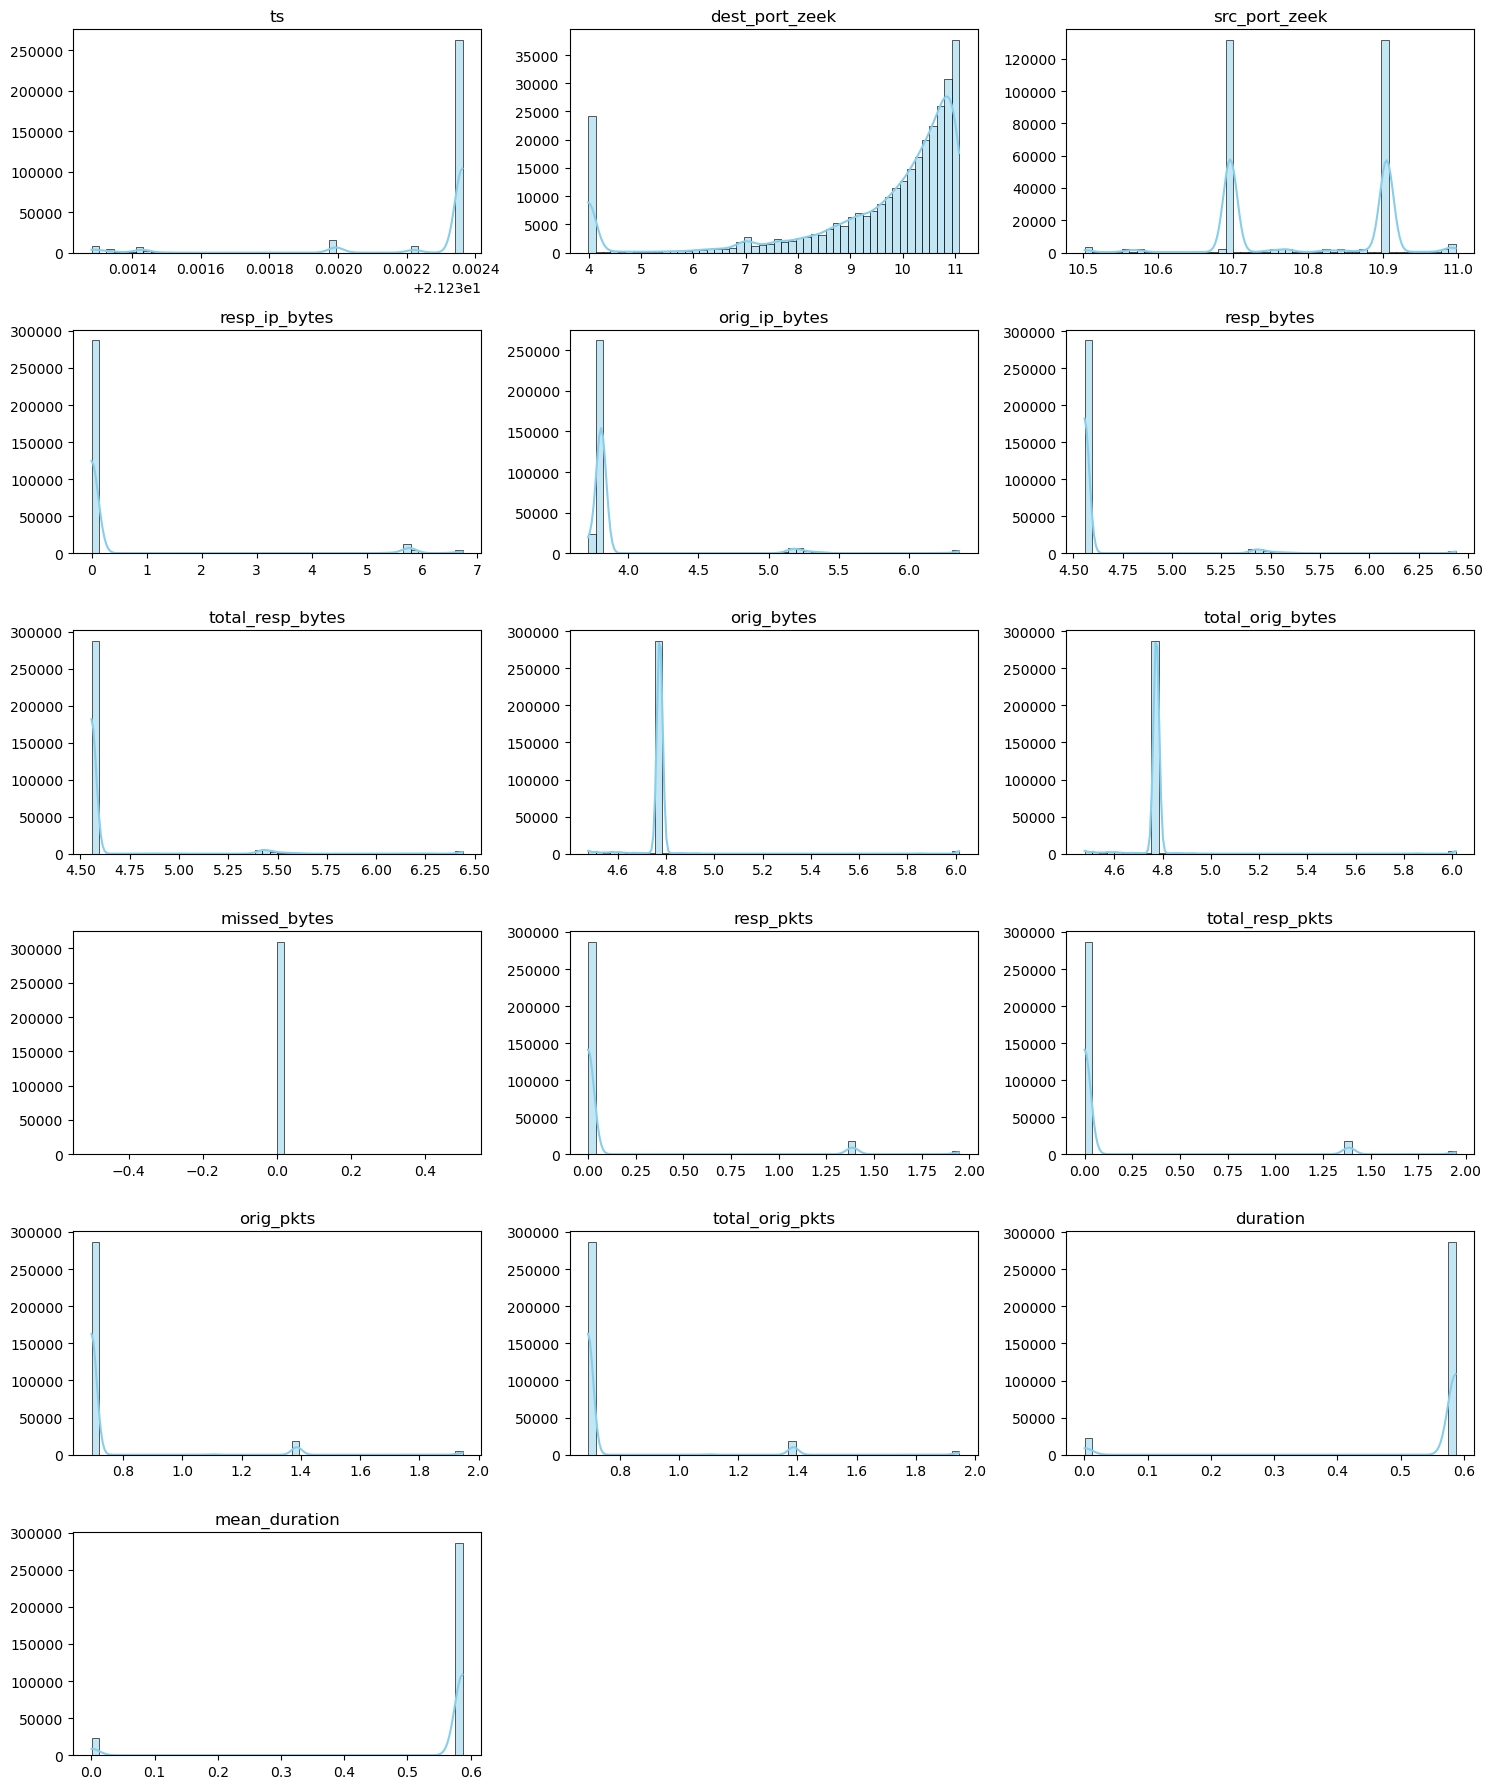

In [19]:
# ==========================================================
# BLOCCO 5: Analisi feature numeriche, gestione outlier e trasformazione robusta
# ==========================================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

# ================================
# Step 0: Pulizia sicura della label_binary
# ================================
data['label_binary_clean'] = data['label_binary'].map({True:1, False:0, 'True':1, 'False':0, 1:1, 0:0})
data = data.dropna(subset=['label_binary_clean'])
data['label_binary'] = data['label_binary_clean'].astype(int)
data = data.drop(columns=['label_binary_clean'])

# ================================
# Step 1: Selezione feature numeriche
# ================================
num_features = data.select_dtypes(include=['int64','float64']).columns.tolist()
for col in ['label_binary','label_technique','label_tactic']:
    if col in num_features:
        num_features.remove(col)

# ================================
# Step 2: Varianza
# ================================
variance = data[num_features].var().sort_values(ascending=False)
selected_features = variance[variance > 0.01].index.tolist()
print(f"‚úÖ Feature con varianza significativa: {selected_features}")

# ================================
# Step 3: Analisi outlier
# ================================
outlier_summary = {}
for col in selected_features:
    Q1, Q3 = data[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    outlier_summary[col] = ((data[col]<lower) | (data[col]>upper)).sum()
print("‚ö†Ô∏è Numero di outlier trovati per feature:")
display(pd.Series(outlier_summary))

# ================================
# Step 4: Trasformazione outlier (Winsorization + log)
# ================================
print("üèóÔ∏è Applicazione trasformazioni per gestire outlier...\n")
for col in selected_features:
    lower = data[col].quantile(0.01)
    upper = data[col].quantile(0.99)
    data[col] = np.clip(data[col], lower, upper)
    min_val = data[col].min()
    offset = abs(min_val)+1e-6 if min_val <= 0 else 0
    data[col] = np.log1p(data[col] + offset)
    data[col].replace([np.inf, -np.inf], np.nan, inplace=True)

# üîß Fix: rimozione eventuali NaN residui
data = data.dropna(subset=selected_features)

# ================================
# Step 5: Analisi post-transform
# ================================
print("\nüìÑ REPORT FINALE - Dataset post Winsorization + log\n")
print("üîπ Statistiche descrittive:")
display(data[selected_features].describe().T)

print("\nüìù Motivazione trasformazione:")
print(
    "- Alcune feature avevano outlier estremi che potevano distorcere le distribuzioni.\n"
    "- Winsorization: limita i valori ai percentili 1% e 99%, riducendo l'impatto degli outlier.\n"
    "- Log-transform: riduce l'asimmetria e migliora la stabilit√† numerica.\n"
    "- Il dataset risultante ha distribuzioni pi√π compatte e valori pronti per scaling/normalizzazione."
)

# ================================
# Step 6: Visualizzazione distribuzioni post-transform
# ================================
cols = 3
rows = math.ceil(len(selected_features)/cols)
plt.figure(figsize=(max(10, cols*5), max(5, rows*3)))
for i, col in enumerate(selected_features, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(data[col].dropna(), bins=50, kde=True, color='skyblue')
    plt.title(col)
    plt.xlabel('')
    plt.ylabel('')
plt.tight_layout()
plt.show()

In [20]:
# ==========================================================
# BLOCCO 6: Analisi esplorativa completa delle feature categoriali
# ==========================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy

print("üìå Analisi esplorativa completa delle feature categoriali...\n")

# ================================
# Step 1: Tabella riassuntiva
# ================================
cat_summary_df = pd.DataFrame(columns=[
    'Feature', 'Num_Categorie', 'Percentuale_unica', 'Entropia', 'Valori_rari(<1%)'
])

total_rows = len(data)

for col in cat_features:
    counts = data[col].value_counts()
    freqs = data[col].value_counts(normalize=True)
    num_unique = data[col].nunique()
    perc_unique = num_unique / total_rows * 100
    rare_count = (freqs < 0.01).sum()
    ent = entropy(freqs)
    
    cat_summary_df = pd.concat([
        cat_summary_df,
        pd.DataFrame({
            'Feature':[col],
            'Num_Categorie':[num_unique],
            'Percentuale_unica':[perc_unique],
            'Entropia':[ent],
            'Valori_rari(<1%)':[rare_count]
        })
    ], ignore_index=True)

# Ordinamento per cardinalit√† decrescente
cat_summary_df = cat_summary_df.sort_values('Num_Categorie', ascending=False).reset_index(drop=True)
display(cat_summary_df)

print(f"‚úÖ Totale righe dataset: {total_rows}\n")



üìå Analisi esplorativa completa delle feature categoriali...



C:\Users\maria\AppData\Local\Temp\ipykernel_25304\1891598749.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cat_summary_df = pd.concat([


Feature Num_Categorie  Percentuale_unica   Entropia  \
0               uid        310034         100.000000  12.644437   
1      community_id        306637          98.904314  12.628495   
2           history            46           0.014837   0.597439   
3      dest_ip_zeek            22           0.007096   0.588346   
4   label_technique            20           0.006451   0.618405   
5       src_ip_zeek            16           0.005161   0.637643   
6           service            14           0.004516   0.005277   
7        conn_state            10           0.003225   0.580017   
8      label_tactic            10           0.003225   0.559670   
9             proto             2           0.000645   0.267489   
10     label_binary             1           0.000323   0.000000   

   Valori_rari(<1%)  
0            660373  
1            392886  
2                81  
3                79  
4                20  
5                48  
6                16  
7                 7  
8                10  
9                 1  
10                0

‚úÖ Totale righe dataset: 310034



In [21]:
# ==========================================================
# BLOCCO 7: Gestione feature categoriali per Autoencoder
# ==========================================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import FeatureHasher

print("üìå Gestione feature categoriali per Autoencoder...\n")

# ================================
# Step 0: Escludi feature inutili o costanti
# ================================
exclude_features = ['uid', 'community_id', 'label_binary']
cat_features_clean = [col for col in cat_features if col not in exclude_features]
print(f"Feature categoriali considerate: {cat_features_clean}\n")

# ================================
# Step 1: Aggregazione valori rari (<1%)
# ================================
for col in cat_features_clean:
    freqs = data[col].value_counts(normalize=True)
    rare_cats = freqs[freqs < 0.01].index
    data[col] = data[col].replace(rare_cats, 'Other')

print("‚úÖ Valori rari (<1%) aggregati in 'Other'.")

# ================================
# Step 2: Separazione per tipo encoding
# ================================
# Consideriamo medium-low cardinality <=50 per OHE
ohe_features = [col for col in cat_features_clean if data[col].nunique() <= 50]
# High cardinality >50 per Hashing
hash_features = [col for col in cat_features_clean if data[col].nunique() > 50]

print(f"üîπ One-Hot Encoding: {ohe_features}")
print(f"üîπ Hashing Encoding: {hash_features}\n")

# ================================
# Step 3: One-Hot Encoding per medium-low cardinality
# ================================
ohe = OneHotEncoder(sparse_output=False, drop='first')
if ohe_features:
    X_ohe = ohe.fit_transform(data[ohe_features])
    ohe_cols = ohe.get_feature_names_out(ohe_features)
    print(f"‚úÖ One-Hot Encoding completato: {X_ohe.shape[1]} colonne generate.")
else:
    X_ohe = np.empty((len(data),0))
    ohe_cols = []

# ================================
# Step 4: Hashing Encoding per high cardinality
# ================================
# Decidiamo numero di hash bins (es. 32 per feature)
hash_bins = 32
X_hash_list = []

for col in hash_features:
    hasher = FeatureHasher(n_features=hash_bins, input_type='string')
    X_col_hashed = hasher.transform(data[col].astype(str))
    X_hash_list.append(X_col_hashed.toarray())

if X_hash_list:
    X_hash = np.hstack(X_hash_list)
    print(f"‚úÖ Hashing Encoding completato: {X_hash.shape[1]} colonne generate.")
else:
    X_hash = np.empty((len(data),0))

# ================================
# Step 5: Dataset finale categoriali pronto per Autoencoder
# ================================
X_cat_final = np.hstack([X_ohe, X_hash])
print(f"‚úÖ Dataset categoriali pronto: {X_cat_final.shape[0]} righe, {X_cat_final.shape[1]} colonne\n")

# Opzionale: salva in .npy per addestramento autoencoder
np.save(r"C:\Users\maria\Desktop\Zeek_ML\processed_zeekdata22\X_cat_final.npy", X_cat_final)
print("üíæ Dataset categoriali salvato come .npy per Autoencoder.")


üìå Gestione feature categoriali per Autoencoder...

Feature categoriali considerate: ['conn_state', 'history', 'src_ip_zeek', 'dest_ip_zeek', 'proto', 'service', 'label_tactic', 'label_technique']

‚úÖ Valori rari (<1%) aggregati in 'Other'.
üîπ One-Hot Encoding: ['conn_state', 'history', 'src_ip_zeek', 'dest_ip_zeek', 'proto', 'service', 'label_tactic', 'label_technique']
üîπ Hashing Encoding: []

‚úÖ One-Hot Encoding completato: 26 colonne generate.
‚úÖ Dataset categoriali pronto: 310034 righe, 26 colonne

üíæ Dataset categoriali salvato come .npy per Autoencoder.


In [22]:
# ==========================================================
# BLOCCO 8: Unione feature numeriche e categoriali + scaling
# ==========================================================
from sklearn.preprocessing import MinMaxScaler

print("üèóÔ∏è Preparazione dataset finale per Autoencoder...\n")

# 1Ô∏è‚É£ Estrazione feature numeriche selezionate dal BLOCCO 4
X_num = data[selected_features].to_numpy()
print(f"üîπ Feature numeriche: {X_num.shape[1]} colonne")

# 2Ô∏è‚É£ Feature categoriali gi√† preprocessate dal BLOCCO 6
print(f"üîπ Feature categoriali: {X_cat_final.shape[1]} colonne")

# 3Ô∏è‚É£ Concatenazione numeriche + categoriali
X_full = np.hstack([X_num, X_cat_final])
print(f"‚úÖ Dataset combinato: {X_full.shape[0]} righe, {X_full.shape[1]} colonne")

# 4Ô∏è‚É£ Scaling tra 0 e 1
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_full)
print("‚úÖ Scaling completato (MinMax 0-1)")

# 5Ô∏è‚É£ Salvataggio finale
np.save(r"C:\Users\maria\Desktop\Zeek_ML\processed_zeekdata22\X_autoencoder_final.npy", X_scaled)
print("üíæ Dataset finale salvato come .npy per Autoencoder")


üèóÔ∏è Preparazione dataset finale per Autoencoder...

üîπ Feature numeriche: 16 colonne
üîπ Feature categoriali: 26 colonne
‚úÖ Dataset combinato: 310034 righe, 42 colonne
‚úÖ Scaling completato (MinMax 0-1)
üíæ Dataset finale salvato come .npy per Autoencoder


üèóÔ∏è Avvio Autoencoder con training riproducibile...
Epoch 1/40 [------------------------------] loss=0.004461 val=0.201065 time=10.91s
Epoch 2/40 [‚îÅ-----------------------------] loss=0.002774 val=0.194536 time=10.58s
Epoch 3/40 [‚îÅ‚îÅ----------------------------] loss=0.001434 val=0.191483 time=8.58s
Epoch 4/40 [‚îÅ‚îÅ‚îÅ---------------------------] loss=0.000490 val=0.188135 time=8.46s
Epoch 5/40 [‚îÅ‚îÅ‚îÅ---------------------------] loss=0.001541 val=0.192260 time=8.51s
Epoch 6/40 [‚îÅ‚îÅ‚îÅ‚îÅ--------------------------] loss=0.001637 val=0.180709 time=8.62s
Epoch 7/40 [‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ-------------------------] loss=0.000472 val=0.173542 time=8.54s
Epoch 8/40 [‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ------------------------] loss=0.000325 val=0.184012 time=8.55s
Epoch 9/40 [‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ------------------------] loss=0.000216 val=0.185876 time=8.93s
Epoch 10/40 [‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ-----------------------] loss=0.000188 val=0.186775 time=7.06s
Epoch 11/40 [‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ----------

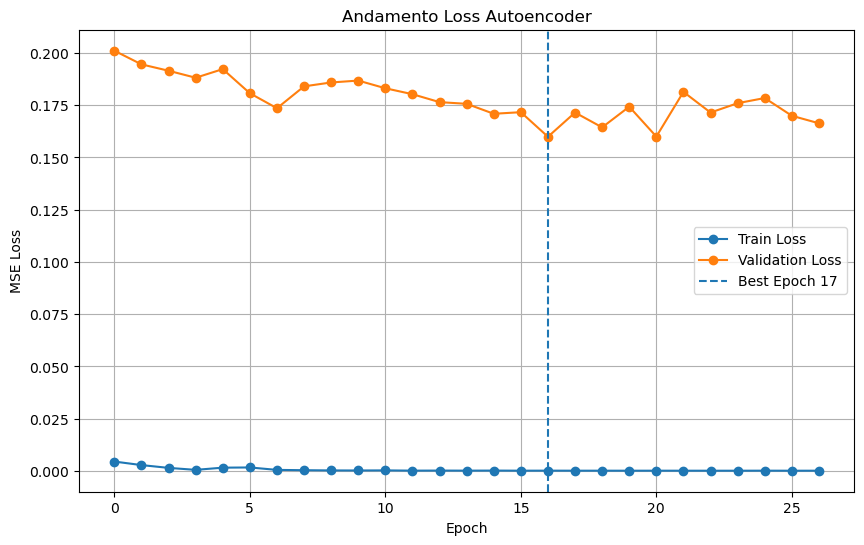

In [23]:
# ==========================================================
# BLOCCO 9: Autoencoder stabile con seed fisso, reset TF,
# EarlyStopping, logging avanzato e salvataggio embeddings
# ==========================================================

import os, gc, random, time
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping
import pandas as pd
import matplotlib.pyplot as plt

# --- ‚úÖ Determinismo per stabilit√† ---
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)
tf.config.experimental.enable_op_determinism()

# --- ‚úÖ Reset memoria e sessione ---
tf.keras.backend.clear_session()
gc.collect()

print("üèóÔ∏è Avvio Autoencoder con training riproducibile...")

# 1Ô∏è‚É£ Parametri
input_dim = X_scaled.shape[1]
latent_dim = 16
epochs = 40
batch_size = 64
validation_split = 0.1

# 2Ô∏è‚É£ Costruzione autoencoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)
encoded = Dense(latent_dim, activation='relu', name='latent_vector')(encoded)

decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(0.001), loss='mse')

# 3Ô∏è‚É£ EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=1e-4,
    restore_best_weights=True,
    verbose=1
)

# 4Ô∏è‚É£ Logger
class ProgressLogger(Callback):
    def on_train_begin(self, logs=None):
        self.epoch_logs = []

    def on_epoch_begin(self, epoch, logs=None):
        self.start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        t = time.time() - self.start
        self.epoch_logs.append({
            'epoch': epoch + 1,
            'loss': logs['loss'],
            'val_loss': logs['val_loss'],
            'time_s': t
        })
        bar = "‚îÅ" * (30 * (epoch+1) // self.params['epochs'])
        bar += "-" * (30 - len(bar))
        print(f"Epoch {epoch+1}/{epochs} [{bar}] loss={logs['loss']:.6f} val={logs['val_loss']:.6f} time={t:.2f}s")

logger = ProgressLogger()

# 5Ô∏è‚É£ ‚úÖ Training (shuffle OFF per stabilit√†)
history = autoencoder.fit(
    X_scaled, X_scaled,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=validation_split,
    shuffle=False,
    callbacks=[early_stop, logger],
    verbose=0
)

print("\n‚úÖ Training completato.")

# 6Ô∏è‚É£ Best epoch
best_idx = np.argmin(history.history['val_loss'])
print(f"üèÜ Best epoch: {best_idx + 1}")
print(f"   Train loss: {history.history['loss'][best_idx]:.6f}")
print(f"   Val loss: {history.history['val_loss'][best_idx]:.6f}")
print(f"   Time per epoch: {logger.epoch_logs[best_idx]['time_s']:.2f}s")

# 7Ô∏è‚É£ Estrazione modello encoder
encoder = Model(inputs=input_layer, outputs=autoencoder.get_layer('latent_vector').output)

# 8Ô∏è‚É£ Embeddings latenti
X_latent = encoder.predict(X_scaled, verbose=0)
latent_cols = [f'latent_{i}' for i in range(latent_dim)]
X_embeddings = pd.DataFrame(X_latent, columns=latent_cols)

# 9Ô∏è‚É£ Salvataggio embeddings
np.save(r"C:\Users\maria\Desktop\Zeek_ML\processed_zeekdata22\X_autoencoder_latent.npy", X_latent)
np.save(r"C:\Users\maria\Desktop\Zeek_ML\processed_zeekdata22\labels.npy", data['label_technique'].values)

print(f"üíæ Salvati {X_embeddings.shape[0]} embeddings da {latent_dim} dimensioni")

# üîü Grafico Train vs Val Loss
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label="Train Loss", marker="o")
plt.plot(history.history['val_loss'], label="Validation Loss", marker="o")
plt.axvline(best_idx, linestyle="--", label=f"Best Epoch {best_idx+1}")
plt.title("Andamento Loss Autoencoder")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.legend()
plt.show()


üìä Analisi esplorativa degli embeddings latenti...
üîπ Varianza spiegata PCA: PC1 = 66.95% | PC2 = 16.30%


C:\Users\maria\AppData\Local\Temp\ipykernel_25304\2989630163.py:46: UserWarning: Glyph 127752 (\N{RAINBOW}) missing from current font.
  plt.tight_layout()
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127752 (\N{RAINBOW}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


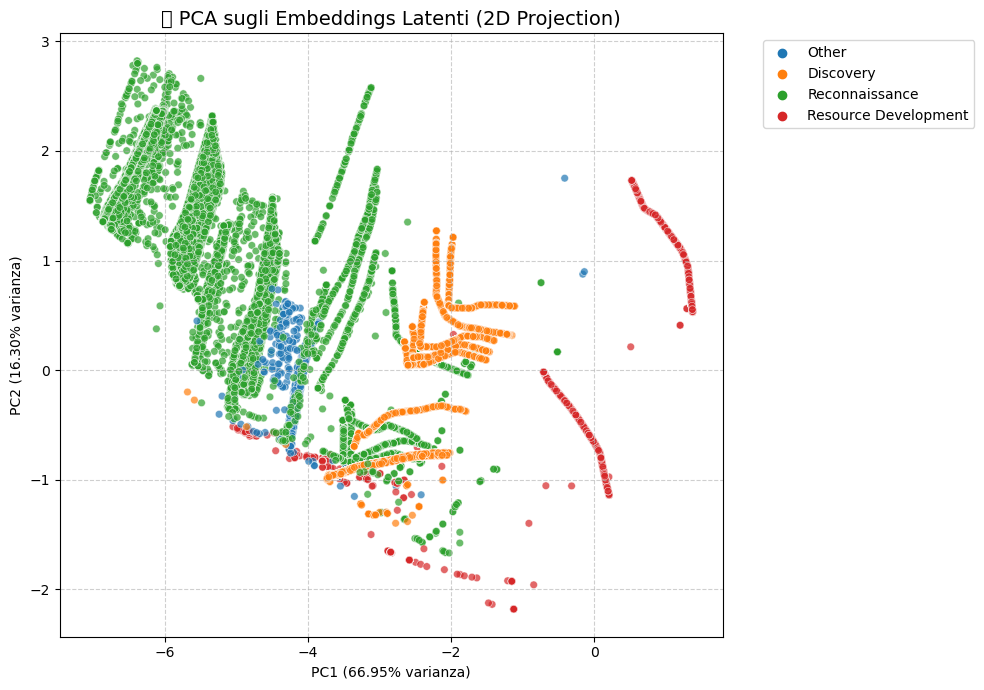

‚öôÔ∏è Esecuzione t-SNE (potrebbe richiedere 1-2 minuti)...


C:\Users\maria\AppData\Local\Temp\ipykernel_25304\2989630163.py:95: UserWarning: Glyph 127744 (\N{CYCLONE}) missing from current font.
  plt.tight_layout()
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127744 (\N{CYCLONE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


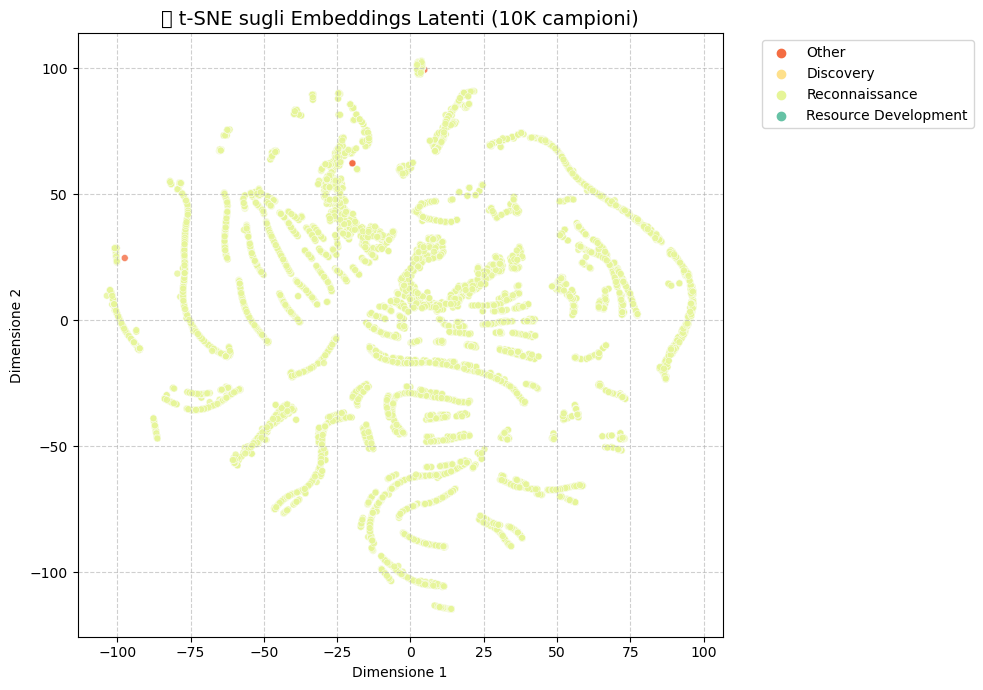

mean       std  min       max
latent_0  0.034586  0.197865  0.0  3.554034
latent_1  3.290101  1.261630  0.0  4.413107
latent_2  0.108461  0.176031  0.0  4.772242
latent_3  0.203508  0.546016  0.0  7.039928
latent_4  2.066186  0.888698  0.0  4.451644
latent_5  2.613748  0.931777  0.0  4.087889
latent_6  0.011597  0.111887  0.0  2.707830
latent_7  0.010804  0.090357  0.0  2.657912
latent_8  0.084860  0.377779  0.0  3.019432
latent_9  0.129898  0.509804  0.0  4.359233

C:\Users\maria\AppData\Local\Temp\ipykernel_25304\2989630163.py:110: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.tight_layout()
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


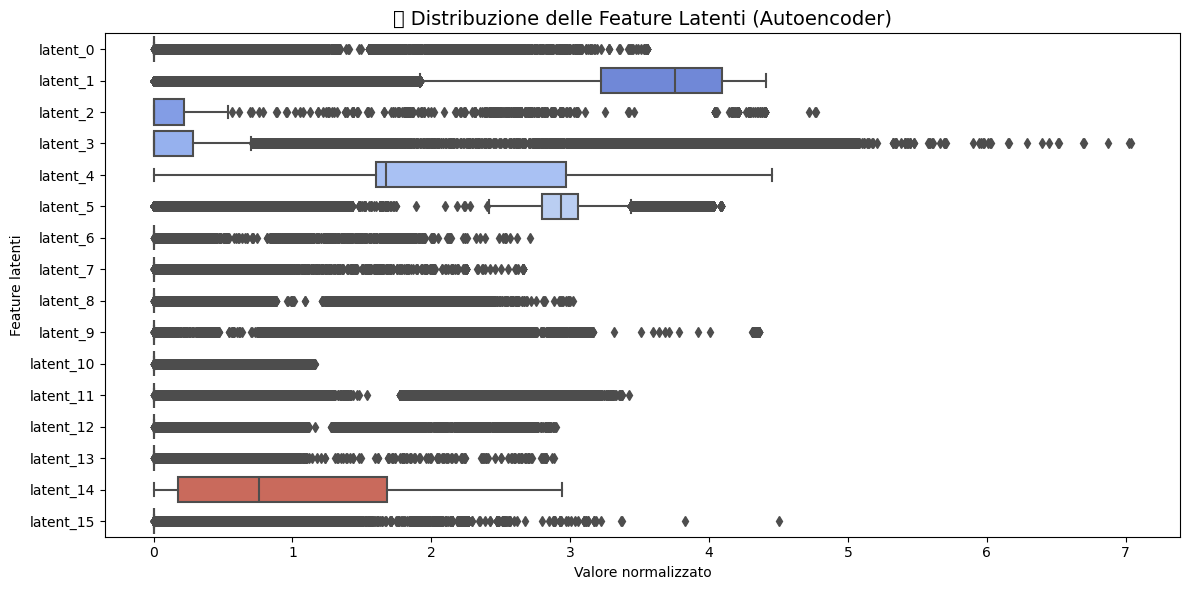

‚úÖ Analisi embeddings completata con successo.


In [24]:
# ==========================================================
# BLOCCO 10: Analisi e Visualizzazione degli Embeddings Latenti (Autoencoder)
# ==========================================================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd

print("üìä Analisi esplorativa degli embeddings latenti...")

# 1Ô∏è‚É£ Caricamento embeddings (se serve)
# Se hai gi√† in memoria X_embeddings, puoi saltare questa riga
# X_latent = np.load(r"C:\Users\maria\Desktop\Zeek_ML\processed_zeekdata22\X_autoencoder_latent.npy")
# X_embeddings = pd.DataFrame(X_latent, columns=[f'latent_{i}' for i in range(X_latent.shape[1])])

# Aggiunta etichette (se presenti nel dataset originale)
if 'label_tactic' in data.columns:
    X_embeddings['label_tactic'] = data['label_tactic'].values
if 'label_technique' in data.columns:
    X_embeddings['label_technique'] = data['label_technique'].values


# ----------------------------------------------------------
# 2Ô∏è‚É£ PCA - Riduzione lineare della dimensionalit√†
# ----------------------------------------------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_latent)
explained_var = pca.explained_variance_ratio_ * 100
print(f"üîπ Varianza spiegata PCA: PC1 = {explained_var[0]:.2f}% | PC2 = {explained_var[1]:.2f}%")

pca_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'label_tactic': data['label_tactic'].values if 'label_tactic' in data.columns else 'unknown'
})

plt.figure(figsize=(10, 7))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='label_tactic', palette='tab10', s=30, alpha=0.7)
plt.title("üåà PCA sugli Embeddings Latenti (2D Projection)", fontsize=14)
plt.xlabel(f"PC1 ({explained_var[0]:.2f}% varianza)")
plt.ylabel(f"PC2 ({explained_var[1]:.2f}% varianza)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# ----------------------------------------------------------
# 3Ô∏è‚É£ t-SNE - Visualizzazione non lineare
# ----------------------------------------------------------
print("‚öôÔ∏è Esecuzione t-SNE (potrebbe richiedere 1-2 minuti)...")

try:
    tsne = TSNE(
        n_components=2,
        perplexity=30,
        max_iter=1000,
        learning_rate='auto',
        random_state=42
    )
except TypeError:
    tsne = TSNE(
        n_components=2,
        perplexity=30,
        n_iter=1000,
        random_state=42
    )

X_tsne = tsne.fit_transform(X_latent[:10000])  # usa un campione per velocit√†

tsne_df = pd.DataFrame({
    'Dim1': X_tsne[:, 0],
    'Dim2': X_tsne[:, 1],
    'label_tactic': data['label_tactic'].values[:10000]
        if 'label_tactic' in data.columns else 'unknown'
})

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=tsne_df,
    x='Dim1',
    y='Dim2',
    hue='label_tactic',
    palette='Spectral',
    s=25,
    alpha=0.8
)
plt.title("üåÄ t-SNE sugli Embeddings Latenti (10K campioni)", fontsize=14)
plt.xlabel("Dimensione 1")
plt.ylabel("Dimensione 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# ----------------------------------------------------------
# 5Ô∏è‚É£ Analisi statistica delle feature latenti
# ----------------------------------------------------------
latent_stats = X_embeddings.describe().T[['mean', 'std', 'min', 'max']]
display(latent_stats.head(10))

plt.figure(figsize=(12, 6))
sns.boxplot(data=X_embeddings.iloc[:, :16], orient='h', palette='coolwarm')
plt.title("üì¶ Distribuzione delle Feature Latenti (Autoencoder)", fontsize=14)
plt.xlabel("Valore normalizzato")
plt.ylabel("Feature latenti")
plt.tight_layout()
plt.show()

print("‚úÖ Analisi embeddings completata con successo.")


‚öôÔ∏è Avvio dello split e bilanciamento controllato (3 classi principali)...
‚ö†Ô∏è Colonne rimosse da X_embeddings (non numeriche o label-like): ['label_tactic', 'label_technique']
‚úÖ Split completato.
 - X_train: (248027, 16)  | X_test: (62007, 16)
 - Distribuzione y_train: {'Resource Development': 209927, 'Discovery': 12816, 'Other': 2355, 'Reconnaissance': 22929}
 - Distribuzione y_test : {'Resource Development': 52482, 'Discovery': 3204, 'Other': 589, 'Reconnaissance': 5732}

üîπ Le 3 classi principali individuate: ['Resource Development', 'Reconnaissance', 'Discovery']
‚úÖ Filtrati train/test sulle top3 classi: ['Resource Development', 'Reconnaissance', 'Discovery']
 - Nuova distribuzione y_train: {'Resource Development': 209927, 'Discovery': 12816, 'Reconnaissance': 22929}
 - Nuova distribuzione y_test : {'Resource Development': 52482, 'Discovery': 3204, 'Reconnaissance': 5732}

üîπ Classe pi√π piccola ha 12816 campioni. Bilanciamento in corso...


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


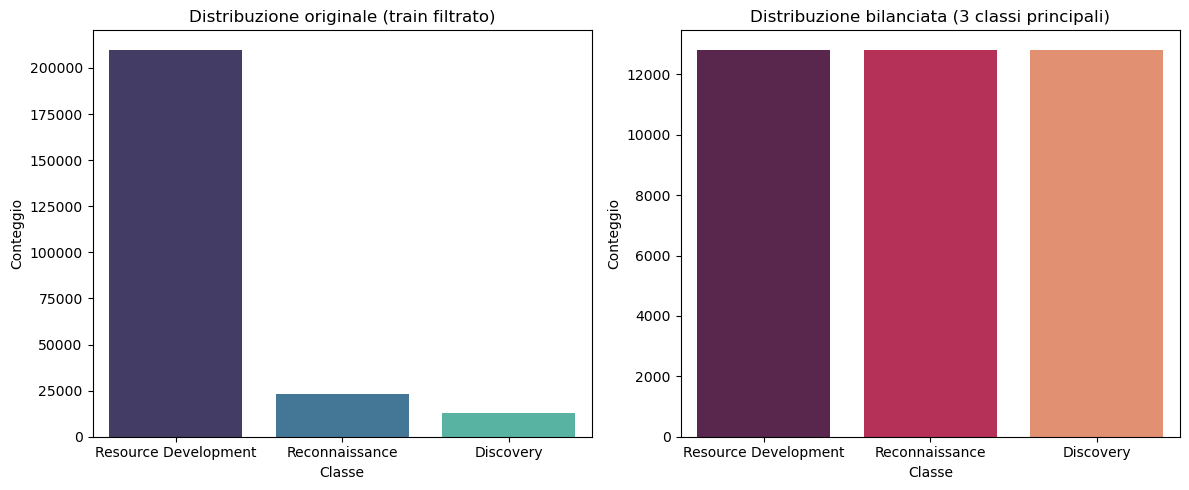


üìÅ Dataset salvati con successo in train_test_bal.npz
   ‚Üí Contiene: train/test originali e train bilanciato con 3 classi principali.


In [25]:
# ==========================================================
# BLOCCO 11 ‚úÖ DEFINITIVO
# Train/Test Split + Bilanciamento controllato (solo 3 classi principali)
# con pulizia automatica delle colonne non numeriche
# ==========================================================

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
import seaborn as sns

print("‚öôÔ∏è Avvio dello split e bilanciamento controllato (3 classi principali)...")

# ----------------------------------------------------------
# 1Ô∏è‚É£ Selezione della label corretta
# ----------------------------------------------------------
# Se esiste la colonna 'label_tactic_reduced', usiamola; altrimenti 'label_tactic'
if 'label_tactic_reduced' in data.columns:
    y_label = data['label_tactic_reduced'].reset_index(drop=True)
else:
    y_label = data['label_tactic'].reset_index(drop=True)

# ----------------------------------------------------------
# 2Ô∏è‚É£ Pulizia delle feature numeriche
# ----------------------------------------------------------
# Elimina eventuali colonne non numeriche o identificatori da X_embeddings
if isinstance(X_embeddings, pd.DataFrame):
    non_numeric_cols = X_embeddings.select_dtypes(exclude=[np.number]).columns.tolist()
    label_like_cols = [c for c in X_embeddings.columns if any(x in c.lower() for x in ['label', 'uid', 'community'])]
    drop_cols = list(set(non_numeric_cols + label_like_cols))

    if drop_cols:
        print(f"‚ö†Ô∏è Colonne rimosse da X_embeddings (non numeriche o label-like): {drop_cols}")
        X_clean = X_embeddings.drop(columns=drop_cols)
    else:
        X_clean = X_embeddings

    X = X_clean.values
else:
    X = X_latent  # fallback nel caso tu abbia gi√† un array latente
y = y_label.values

# ----------------------------------------------------------
# 3Ô∏è‚É£ Split stratificato (mantiene proporzione delle classi)
# ----------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("‚úÖ Split completato.")
print(" - X_train:", X_train.shape, " | X_test:", X_test.shape)
print(" - Distribuzione y_train:", dict(collections.Counter(y_train)))
print(" - Distribuzione y_test :", dict(collections.Counter(y_test)))

# ----------------------------------------------------------
# 4Ô∏è‚É£ Conversione sicura dei tipi (solo float32 per numerici)
# ----------------------------------------------------------
X_train = np.asarray(X_train, dtype=np.float32)
X_test = np.asarray(X_test, dtype=np.float32)

# ----------------------------------------------------------
# 5Ô∏è‚É£ Identificazione delle 3 classi principali
# ----------------------------------------------------------
train_df = pd.DataFrame(X_train, columns=[f'latent_{i}' for i in range(X_train.shape[1])])
train_df['label'] = pd.Series(y_train).astype(str).str.strip()

class_counts = train_df['label'].value_counts()
top3_classes = class_counts.head(3).index.tolist()
print(f"\nüîπ Le 3 classi principali individuate: {top3_classes}")

# ----------------------------------------------------------
# 6Ô∏è‚É£ Filtraggio del dataset solo sulle top3 classi
# ----------------------------------------------------------
mask_train = np.isin(y_train, top3_classes)
mask_test = np.isin(y_test, top3_classes)

X_train = X_train[mask_train]
y_train = y_train[mask_train]
X_test = X_test[mask_test]
y_test = y_test[mask_test]

print(f"‚úÖ Filtrati train/test sulle top3 classi: {top3_classes}")
print(" - Nuova distribuzione y_train:", dict(collections.Counter(y_train)))
print(" - Nuova distribuzione y_test :", dict(collections.Counter(y_test)))

# ----------------------------------------------------------
# 7Ô∏è‚É£ Bilanciamento controllato (undersampling)
# ----------------------------------------------------------
train_df = pd.DataFrame(X_train, columns=[f'latent_{i}' for i in range(X_train.shape[1])])
train_df['label'] = pd.Series(y_train).astype(str).str.strip()

valid_counts = train_df['label'].value_counts()
valid_top3 = [cls for cls in top3_classes if cls in valid_counts.index and valid_counts[cls] > 0]

if len(valid_top3) < 2:
    raise ValueError(f"‚ùå Bilanciamento impossibile: classi valide trovate solo {valid_top3}")

min_class_size = valid_counts[valid_top3].min()
print(f"\nüîπ Classe pi√π piccola ha {min_class_size} campioni. Bilanciamento in corso...")

balanced_list = []
for cls in valid_top3:
    cls_df = train_df[train_df['label'] == cls]
    cls_bal = resample(cls_df, replace=False, n_samples=min_class_size, random_state=42)
    balanced_list.append(cls_bal)

train_balanced_df = pd.concat(balanced_list).sample(frac=1, random_state=42).reset_index(drop=True)

X_train_bal = train_balanced_df.drop(columns=['label']).apply(pd.to_numeric, errors='coerce').values.astype(np.float32)
y_train_bal = train_balanced_df['label'].astype(str).values

# ----------------------------------------------------------
# 8Ô∏è‚É£ Visualizzazione grafica delle distribuzioni
# ----------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(x=y_train, order=top3_classes, ax=axes[0], palette="mako")
axes[0].set_title("Distribuzione originale (train filtrato)")
axes[0].set_xlabel("Classe")
axes[0].set_ylabel("Conteggio")

sns.countplot(x=y_train_bal, order=top3_classes, ax=axes[1], palette="rocket")
axes[1].set_title("Distribuzione bilanciata (3 classi principali)")
axes[1].set_xlabel("Classe")
axes[1].set_ylabel("Conteggio")

plt.tight_layout()
plt.show()

# ----------------------------------------------------------
# 9Ô∏è‚É£ Salvataggio dataset bilanciati e originali
# ----------------------------------------------------------
np.savez_compressed(
    r"C:\Users\maria\Desktop\Zeek_ML\processed_zeekdata22\train_test_bal.npz",
    X_train=X_train.astype(np.float32),
    X_test=X_test.astype(np.float32),
    y_train=y_train.astype(str),
    y_test=y_test.astype(str),
    X_train_bal=X_train_bal,
    y_train_bal=y_train_bal
)

print("\nüìÅ Dataset salvati con successo in train_test_bal.npz")
print("   ‚Üí Contiene: train/test originali e train bilanciato con 3 classi principali.")


üìä Riepilogo distribuzione classi (train set):


Classe  Conteggio originale  Conteggio bilanciato
0  Resource Development               209927                 12816
1        Reconnaissance                22929                 12816
2             Discovery                12816                 12816

C:\Users\maria\AppData\Local\Temp\ipykernel_25304\2092122580.py:35: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


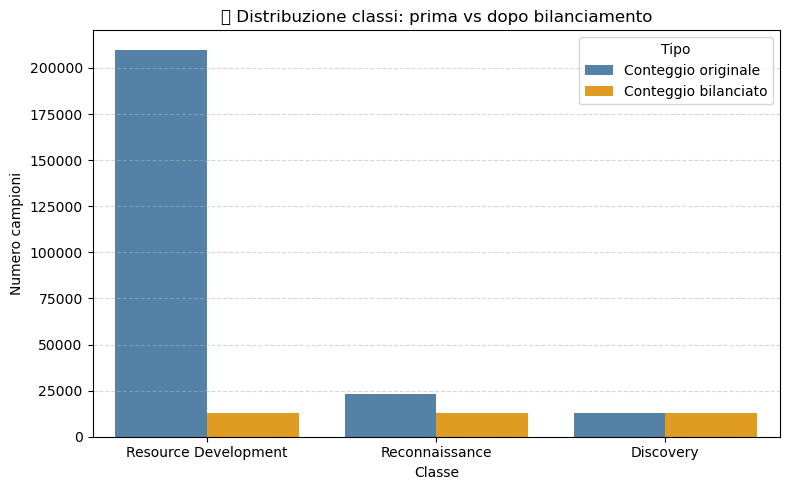

In [26]:
# ==========================================================
# BLOCCO 12: Riepilogo distribuzione classi (prima e dopo bilanciamento)
# ==========================================================
import pandas as pd

# Conteggi originali (solo top3 classi)
original_counts = pd.Series(y_train).value_counts()[top3_classes]

# Conteggi bilanciati
balanced_counts = pd.Series(y_train_bal).value_counts()[top3_classes]

# Creazione DataFrame riepilogo
summary_df = pd.DataFrame({
    "Classe": top3_classes,
    "Conteggio originale": original_counts.values,
    "Conteggio bilanciato": balanced_counts.values
})

# Mostra la tabella
print("üìä Riepilogo distribuzione classi (train set):")
display(summary_df)

# Grafico a barre comparativo (opzionale)
import matplotlib.pyplot as plt
import seaborn as sns

summary_melted = summary_df.melt(id_vars='Classe', var_name='Tipo', value_name='Conteggio')

plt.figure(figsize=(8,5))
sns.barplot(data=summary_melted, x='Classe', y='Conteggio', hue='Tipo', palette=['steelblue','orange'])
plt.title("üìà Distribuzione classi: prima vs dopo bilanciamento")
plt.ylabel("Numero campioni")
plt.xlabel("Classe")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


‚öôÔ∏è Avvio split, pulizia e calcolo class weights (versione semplice)...
‚ö†Ô∏è Colonne rimosse da X_embeddings: ['label_tactic', 'label_technique']
‚úÖ Split completato.
 - X_train: (248027, 16) | X_test: (62007, 16)
 - Distribuzione y_train: {'Resource Development': 209927, 'Discovery': 12816, 'Other': 2355, 'Reconnaissance': 22929}
 - Distribuzione y_test : {'Resource Development': 52482, 'Discovery': 3204, 'Other': 589, 'Reconnaissance': 5732}

üìè Class weights calcolati:
 - Discovery           : 4.8382
 - Other               : 26.3298
 - Reconnaissance      : 2.7043
 - Resource Development: 0.2954


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


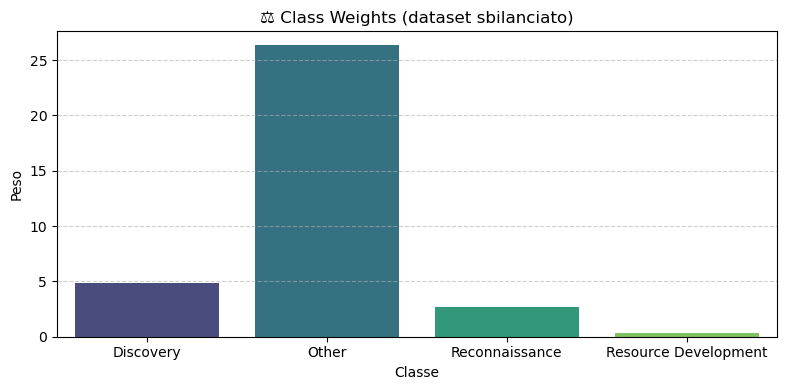


üìÅ Salvati:
   - train_test_unbal.npz ‚Üí dataset sbilanciato (train/test originali)
   - class_weights_unbal.npy ‚Üí pesi per classe
   - class_weights_plot.png ‚Üí grafico salvato in:
     C:\Users\maria\Desktop\Zeek_ML\processed_zeekdata22\class_weights_plot.png

‚úÖ BLOCCO COMPLETATO SENZA ERRORI.


In [27]:
# ==========================================================
# BLOCCO FINALE ‚úÖ
# Dataset sbilanciato ‚Äî calcolo class weights base + grafico
# ==========================================================
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

print("‚öôÔ∏è Avvio split, pulizia e calcolo class weights (versione semplice)...")

# ----------------------------------------------------------
# 1Ô∏è‚É£ Selezione label corretta
# ----------------------------------------------------------
if 'label_tactic_reduced' in data.columns:
    y_label = data['label_tactic_reduced'].reset_index(drop=True)
else:
    y_label = data['label_tactic'].reset_index(drop=True)

# ----------------------------------------------------------
# 2Ô∏è‚É£ Pulizia feature numeriche da X_embeddings
# ----------------------------------------------------------
if isinstance(X_embeddings, pd.DataFrame):
    X_df = X_embeddings.copy()
else:
    X_df = pd.DataFrame(X_latent)

# Rimuove colonne non numeriche o che contengono label/id
non_numeric = X_df.select_dtypes(exclude=[np.number]).columns.tolist()
label_like = [c for c in X_df.columns if any(x in c.lower() for x in ['label', 'uid', 'id', 'community', 'technique', 'tactic'])]
drop_cols = list(dict.fromkeys(non_numeric + label_like))
if drop_cols:
    print(f"‚ö†Ô∏è Colonne rimosse da X_embeddings: {drop_cols}")
    X_df = X_df.drop(columns=drop_cols)

X_df = X_df.fillna(0)
X = X_df.values.astype(np.float32)
y = y_label.values

# ----------------------------------------------------------
# 3Ô∏è‚É£ Split stratificato
# ----------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("‚úÖ Split completato.")
print(" - X_train:", X_train.shape, "| X_test:", X_test.shape)
print(" - Distribuzione y_train:", dict(collections.Counter(y_train)))
print(" - Distribuzione y_test :", dict(collections.Counter(y_test)))

# ----------------------------------------------------------
# 4Ô∏è‚É£ Calcolo class weights base (frequenza inversa)
# ----------------------------------------------------------
classes = np.unique(y_train)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, weights))

print("\nüìè Class weights calcolati:")
for cls, w in class_weight_dict.items():
    print(f" - {cls:<20}: {w:.4f}")

# ----------------------------------------------------------
# 5Ô∏è‚É£ Visualizzazione class weights
# ----------------------------------------------------------
plt.figure(figsize=(8,4))
sns.barplot(x=list(class_weight_dict.keys()), y=list(class_weight_dict.values()), palette="viridis")
plt.title("‚öñÔ∏è Class Weights (dataset sbilanciato)")
plt.ylabel("Peso")
plt.xlabel("Classe")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

save_path = r"C:\Users\maria\Desktop\Zeek_ML\processed_zeekdata22\class_weights_plot.png"
plt.savefig(save_path, dpi=300)
plt.show()

# ----------------------------------------------------------
# 6Ô∏è‚É£ Salvataggio risultati
# ----------------------------------------------------------
np.savez_compressed(
    r"C:\Users\maria\Desktop\Zeek_ML\processed_zeekdata22\train_test_unbal.npz",
    X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test
)
np.save(r"C:\Users\maria\Desktop\Zeek_ML\processed_zeekdata22\class_weights_unbal.npy", class_weight_dict)

print("\nüìÅ Salvati:")
print("   - train_test_unbal.npz ‚Üí dataset sbilanciato (train/test originali)")
print("   - class_weights_unbal.npy ‚Üí pesi per classe")
print(f"   - class_weights_plot.png ‚Üí grafico salvato in:\n     {save_path}")
print("\n‚úÖ BLOCCO COMPLETATO SENZA ERRORI.")
